## Imports
Importing all required modules

In [16]:
import random # random integers and random shuffling of a list
from itertools import permutations # iterate over all possible permutations of a list
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt, log, factorial  # square root, logarithm, and n!
from time import perf_counter # for measuring time. NB. 'perf_counter' is better/more accurate than 'time'
import networkx as nx # to draw sample graphs
import pandas as pd # to show the adjacency matrix in a nice format
import matplotlib.pyplot as plt # to plot graphs of time and quality vs n
import seaborn as sns # nice statistical plots -- see e.g. https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
sns.set_style("white")

## Defining a Graph
Graph class for creating graphs to use with algorithms. All graphs are complete and weighted.

Supports 4 types of graphs:
- `asymmetric`: Directed graph with random weights
- `symmetric`: Undirected graph with random weights
- `easy`: All edges have the weight 2, except for a cycle which has edges with the weight 1
- `Euclidean`: Vertices placed on a 2D coordinate plane and the weight of the edges is the Euclidean distance between them

Examples:
- Creating a Euclidean graph with 10 vertices: `G = Graph(10, 'Euclidean')`
- Getting the number of vertices: `G.n`
- Getting the weight of the edge from $a$ to $b$: `G[a][b]`

In [4]:
class Graph:
    """ Random graphs """
    def __init__(self, n=0, type="asymmetric", MAX_WEIGHT=100, MAX_X=200, MAX_Y=200):
        self.n = n
        self.vertices = list(range(n)) # [0,1,...,n-1]
        self.type = type
        self.adj_matrix = [[oo for i in range(n)] for j in range(n)]
        # Generate a random adjacency matrix according to the required type
        if type == "symmetric": self.__random_symmetric_graph(n, MAX_WEIGHT)
        elif type == "Euclidean": self.__random_euclidean_graph(n, MAX_X,MAX_Y)
        elif type == "easy": self.__random_cycle_graph(n)
        else: self.__random_asymmetric_graph(n, MAX_WEIGHT) # assume "asymmetric" otherwise
            
    def __getitem__(self, i):
        """ Allow indexing to get the weights """
        return self.adj_matrix[i]
                
    def __random_asymmetric_graph(self, n, MAX_WEIGHT):
        """ Asymmetric adjacency matrix of size nxn """
        for i in range(n):
            for j in range(n):
                if i == j: continue # no self-loops
                self.adj_matrix[i][j] = randint(1, MAX_WEIGHT)

    def __random_symmetric_graph(self, n, MAX_WEIGHT):
        """ Symmetric adjacency matrix of size nxn """
        for i in range(n):
            for j in range(i + 1, n):
                w = randint(1, MAX_WEIGHT)
                self.adj_matrix[i][j] = w
                self.adj_matrix[j][i] = w

    def __random_cycle_graph(self,n):
        """ Symmetric adjacency matrix of size nxn with one reandomly chosen cycle
        All the edge weights are 2 except for the cycle (weight=1) """
        self.adj_matrix = [[2 for _ in range(n)] for _ in range(n)] # All weights=2
        # Select a random cycle which will have weight=1
        cycle = list(range(1, n)) # don't include 0 as we want to be at the start
        shuffle(cycle) # in-place random permutation
        cycle = [0]+cycle+[0] # cycle starting and ending at 0
        for a, b in zip(cycle, cycle[1:]): # set the cycle's weights to 1
            self.adj_matrix[a][b] = 1
            self.adj_matrix[b][a] = 1

    def __random_euclidean_graph(self, n, MAX_X, MAX_Y):
        """ Symmetric adjacency matrix of a Euclidean graph of size nxn """
        # (1/2) Generate random (x,y) points
        points = set()
        while len(points) < n: # We may get duplicate (x,y) so we try until we get enough points
            x, y = randint(0, MAX_X), randint(0, MAX_Y)
            points.add((x, y))
        points = list(points) # Sets are not indexed, so convert into a list
        # (2/2) Now compute the adjacency matrix
        for i in range(n):
            p1 = points[i]
            for j in range(i+1, n):
                p2 = points[j]
                distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
                self.adj_matrix[i][j] = distance
                self.adj_matrix[j][i] = distance
        self.points = points

### Utility functions on the Graph

- **cost(Graph, cycle)**: Calculates the cost of a cycle in the graph (The first and last elements need to be the same in the cycle).
- **show(Graph)**: Displays the adjacency matrix of the graph.
- **draw(Graph, path?)**: Draws the graph. If a path is specified, only draws the edges in the path. The weight of the edges is not shown for graphs that have more than 15 vertices.

In [5]:
def cost(G, cycle):
    """ Calculate the cost of the given cycle [0,...,0] in G """
    return sum(G[a][b] for a, b in zip(cycle, cycle[1:]))

In [6]:
def show(G):
    ''' Show adjacency matrix. Useful for debugging.
    'type' is a string from: Euclidean, Cycle, ...
    The distances are round to 1 decimal point for clarity/simplicity
    '''
    print(f"{G.n}x{G.n} {G.type} graph:")
    if G.type=='Euclidean': print("Points:",G.points)
    r = pd.DataFrame({str(i): G[i] for i in range(G.n)})
    display(r)
    
def nx_graph(G, path=None):
    ''' Convert G into NetworkX format '''
    nxG = nx.Graph() if G.type!='asymmetric' else nx.DiGraph() # undirected/directed graph
    nxG.add_nodes_from(G.vertices) # Add the vertices
    # Now add the edges
    if path is None:
        # If no specific path is given - Add all edges
        for a in G.vertices:
            for b in G.vertices:
                if a==b: continue # no self-loops
                nxG.add_edge(a, b, weight=G[a][b])
    else:
        # If path is given - Add only edges specified in path
        for i in range(len(path) - 1):
            a = path[i]
            b = path[i + 1]
            nxG.add_edge(a, b, weight=G[a][b])
        # Add last edge
        a = path[-1]
        b = path[0]
        nxG.add_edge(a, b, weight=G[a][b])
    if G.type=='Euclidean': # add (x,y) coordinates if available
        pos=dict(enumerate(G.points)) # vertex:(x,y) pairs
        nx.set_node_attributes(nxG, pos, 'coord')
    return nxG

def draw(G, path=None, weight_tags=False):
    ''' Draw the graph G using NetworkX '''
    nxG = nx_graph(G, path)
    weights_dictionary = nx.get_edge_attributes(nxG,'weight')
    edges,weights = zip(*weights_dictionary.items())
    pos = nx.circular_layout(nxG) if G.type!='Euclidean' else nx.get_node_attributes(nxG,'coord')
    nx.draw(nxG, pos, \
            with_labels=True, node_color='red', font_color='white', font_weight='bold', font_size=14,\
            edge_color=weights, width=1.5, connectionstyle="arc3,rad=0.1", edge_cmap=plt.cm.copper)
    # see https://matplotlib.org/stable/gallery/color/colormap_reference.html
    if weight_tags:
        nx.draw_networkx_edge_labels(nxG, pos, edge_labels=weights_dictionary)

Example

5x5 euclidean graph:


,0,1,2,3,4
0,inf,70.0,14.0,4.0,36.0
1,36.0,inf,28.0,88.0,77.0
2,13.0,19.0,inf,11.0,79.0
3,75.0,40.0,6.0,inf,91.0
4,49.0,83.0,50.0,69.0,inf


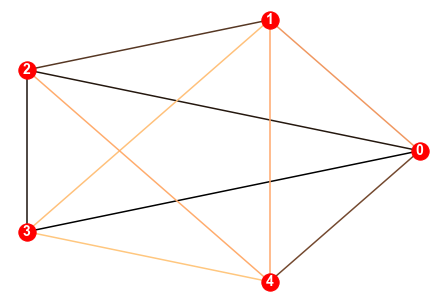

In [7]:
G = Graph(5,"euclidean")
show(G)
draw(G)

# Simulated Annealing

The simulated annealing algorithm is an optimization method which mimics the slow cooling of metals

1. Initial path is formed
1. Algorithm swaps path between two cities at random
1. If cost of overall path is lowered, new path is kept
1. If not then the path still has a chance to be kept which is determined by the temperature
1. The higher the temp, the more chance the path is still swapped.


In [ ]:
def greedy_nearest_neighbour(G):
    ''' Returns best found cycle and its cost '''
    unvisited = G.vertices.copy()
    visited = [] # solution to be built
    city = 0 # Start city
    while len(unvisited)>0:
        # Find nearest neighbour
        nearest_city = None
        shortest_distance = oo
        for neighbour in unvisited:
            if G[city][neighbour] < shortest_distance:
                shortest_distance = G[city][neighbour]
                nearest_city = neighbour
        # Update 'cycle' and 'cities' and G then 'city'
        visited.append(city)
        unvisited.remove(city)
        city = nearest_city
    return (visited, cost(G, visited+[0]))

In [75]:
def SA(G, cooling):
    initial_temp = 100
    final_temp = 0
    current_temp = initial_temp
    best_path, best_cost = greedy_nearest_neighbour(G)
    print('greedy was', best_path, best_cost)
    current_path = best_path
    current_cost = best_cost
    while current_temp > final_temp:
        percentage = (current_temp / 400) * 100
        print('acceptanceChance = ', percentage, '%')
        probability = randint(0, initial_temp+100)
        city = (random.choice(G.vertices))
        # next_city = (random.choice(i for i in G.vertices if i != city))
        next_city = random.choice(G.vertices)
        while city == next_city:
            next_city = random.choice(G.vertices)
        city_pos = current_path.index(city)
        next_city_pos = current_path.index(next_city)
        current_path.remove(next_city)
        current_path.insert(city_pos+1, next_city)
        current_cost = cost(G, current_path)
        if current_cost < best_cost:
            best_path = current_path
            best_cost = current_cost
        else:
            if probability <= current_temp:
                best_path = current_path
                best_cost = current_cost
            current_temp -= cooling  
            print(current_path, current_cost, current_temp)
    return (best_path, best_cost) 
        
        
    

greedy was [0, 2, 3, 4, 1] 237.9709257923147
acceptanceChance =  25.0 %
acceptanceChance =  25.0 %
acceptanceChance =  25.0 %
[0, 2, 4, 3, 1] 179.5985970802278 99
acceptanceChance =  24.75 %
[0, 2, 4, 1, 3] 192.82965333640442 98
acceptanceChance =  24.5 %
acceptanceChance =  24.5 %
[2, 3, 4, 1, 0] 208.90204208481742 97
acceptanceChance =  24.25 %
[2, 1, 3, 4, 0] 234.65831974345872 96
acceptanceChance =  24.0 %
[2, 3, 4, 0, 1] 258.02584181325295 95
acceptanceChance =  23.75 %
[3, 4, 0, 1, 2] 269.50808232633904 94
acceptanceChance =  23.5 %
[3, 4, 0, 1, 2] 269.50808232633904 93
acceptanceChance =  23.25 %
acceptanceChance =  23.25 %
[4, 1, 2, 0, 3] 198.2740466942592 92
acceptanceChance =  23.0 %
[4, 1, 0, 3, 2] 247.74514195309106 91
acceptanceChance =  22.75 %
acceptanceChance =  22.75 %
acceptanceChance =  22.75 %
[4, 3, 1, 2, 0] 173.37234746634385 90
acceptanceChance =  22.5 %
[3, 1, 2, 4, 0] 274.01557621965435 89
acceptanceChance =  22.25 %
acceptanceChance =  22.25 %
[3, 1, 2, 0, 4] 

([3, 0, 2, 1, 4], 159.4309468259856)

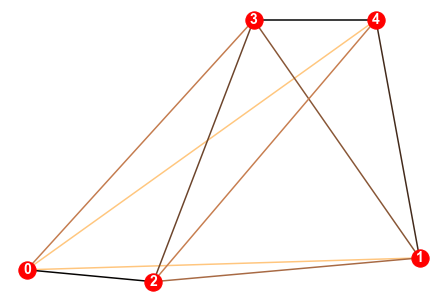

In [76]:
G = Graph(5, "Euclidean")
draw(G)
#show(G)
SA(G, 1)